In [7]:
%pip install requests
%pip install scikit-learn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ------------------------------------ 138.5/138.5 kB 585.7 kB/s eta 0:00:00
   ---------------------------------------- 7.2/7.2 MB 617.9 kB/s eta 0:00:00
   -------------------------------------- 965.4/965.4 kB 745.6 kB/s eta 0:00:00
   ---------------------------------------- 55.8/55.8 kB 484.6 kB/s eta 0:00:00
   ---------------------------------------- 2.5/2.5 MB 731.7 kB/s eta 0:00:00
   -------------------------------------- 103.2/103.2 kB 744.0 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [14]:
import requests
import pandas as pd
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from matplotlib import pyplot as plt
import logging

In [4]:
logging.basicConfig(filename='weather_data_log.txt', level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


api_key = '3b0ca1f1b9885f94ec13872bae2dacd7'


file_path = 'cities_list.xlsx'  
cities_df = pd.read_excel(file_path)


def get_weather_data(lat, lon, api_key, retries=3, timeout=10):
    weather_url = f'http://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={api_key}'
    for i in range(retries):
        try:
            response = requests.get(weather_url, timeout=timeout)
            if response.status_code == 200:
                data = response.json()
                weather = {
                    'latitude': lat,
                    'longitude': lon,
                    'temperature': data['main']['temp'],
                    'humidity': data['main']['humidity'],
                    'wind_speed': data['wind']['speed'],
                    'city': data['name']
                }
                return weather
            else:
                logging.error(f'Error fetching weather data: {response.status_code}')
        except requests.exceptions.Timeout:
            logging.warning(f'Timeout occurred for weather data. Retry {i + 1}/{retries}')
            time.sleep(2)  
        except requests.exceptions.RequestException as e:
            logging.error(f'RequestException: {e}')
            break
    return None


def get_air_pollution_level(lat, lon, api_key, retries=3, timeout=10):
    pollution_url = f'http://api.openweathermap.org/data/2.5/air_pollution?lat={lat}&lon={lon}&appid={api_key}'
    for i in range(retries):
        try:
            pollution_response = requests.get(pollution_url, timeout=timeout)
            if pollution_response.status_code == 200:
                pollution_data = pollution_response.json()
                aqi = pollution_data['list'][0]['main']['aqi']
                
                
                if aqi == 1:
                    air_pollution_level = 'Very Low'
                elif aqi == 2:
                    air_pollution_level = 'Low'
                elif aqi == 3:
                    air_pollution_level = 'Medium'
                else:
                    air_pollution_level = 'High'
                return air_pollution_level
            else:
                logging.error(f'Error fetching air pollution data: {pollution_response.status_code}')
        except requests.exceptions.Timeout:
            logging.warning(f'Timeout occurred for air pollution data. Retry {i + 1}/{retries}')
            time.sleep(2)  
        except requests.exceptions.RequestException as e:
            logging.error(f'RequestException: {e}')
            break
    return None


weather_data_list = []


for index, row in cities_df.iterrows():
    lat = row['lat']
    lon = row['lon']
    weather_data = get_weather_data(lat, lon, api_key)
    if weather_data:
        pollution_level = get_air_pollution_level(lat, lon, api_key)
        if pollution_level:
            weather_data['pollution_level'] = pollution_level
            weather_data_list.append(weather_data)
    time.sleep(1)


weather_df = pd.DataFrame(weather_data_list)
print(weather_df.head())
weather_df.to_excel('weather_pollution_data.xlsx', index=False)


   latitude  longitude  temperature  humidity  wind_speed               city  \
0   5.35444   -4.00167       298.87        89        4.12  Les deux-Plateaux   
1  24.45118   54.39696       310.17        56        5.66            Al Amān   
2   9.05785    7.49508       301.24        58        1.71              Abuja   
3   5.55602   -0.19690       302.38        70        7.72              Accra   
4   9.02497   38.74689       294.64        56        1.76        Addis Ababa   

  pollution_level  
0             Low  
1            High  
2        Very Low  
3             Low  
4          Medium  


In [18]:

api_key = '3b0ca1f1b9885f94ec13872bae2dacd7'


def get_weather_data(lat, lon, api_key):
    weather_url = f'http://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={api_key}'
    response = requests.get(weather_url)
    if response.status_code == 200:
        data = response.json()
        weather = {
            'latitude': lat,
            'longitude': lon,
            'temperature': data['main']['temp'],
            'humidity': data['main']['humidity'],
            'wind_speed': data['wind']['speed'],
            'city': data['name']
        }
        return weather
    else:
        print('Error fetching weather data:', response.status_code)
        return None


weather_data_path = 'weather_pollution_data.xlsx'
weather_df = pd.read_excel(weather_data_path)


X = weather_df[['temperature', 'humidity', 'wind_speed']]  
y = weather_df['pollution_level']  


classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X, y)


city_to_predict = 'Jerusalem'
lat, lon = 31.76904, 35.21633  
weather_data_to_predict = get_weather_data(lat, lon, api_key)
if weather_data_to_predict:
    predicted_pollution_level = classifier.predict([[
        weather_data_to_predict['temperature'],
        weather_data_to_predict['humidity'],
        weather_data_to_predict['wind_speed']
    ]])[0]
    print("Predicted Air Pollution Level for", city_to_predict + ":", predicted_pollution_level)
else:
    print(f'Could not fetch weather data for {city_to_predict}')

Predicted Air Pollution Level for Jerusalem: Low


c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


Accuracy: 100.00%


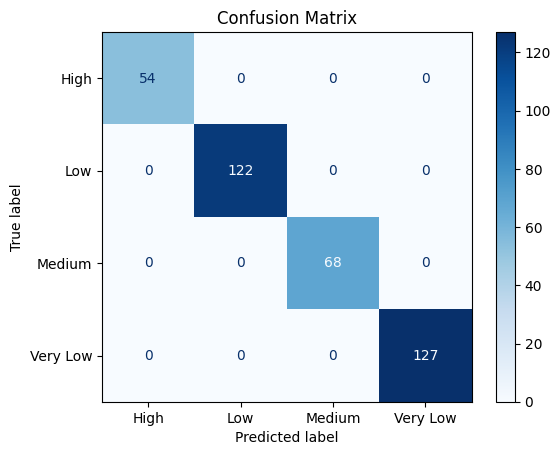

In [15]:
y_pred = classifier.predict(X)


cm = confusion_matrix(y, y_pred, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')


accuracy = accuracy_score(y, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')